# Offer amount prediction EY with regression

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.0.


In [10]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [11]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [12]:
query="""
SELECT * FROM ml_prep.gauthier_offer_amount_prediction_dataset_ey WHERE channel_source IS NOT NULL ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


auto_id                              event_id  offer_id origin dest  \
0  10489204  001f78e7-760d-4c3e-a358-b54e661b9c4b   8501791    DUB  AUH   
1  10489210  001f78e7-760d-4c3e-a358-b54e661b9c4b   8501794    AUH  DUB   
2  10672588  4ae629ed-b6ad-4f8b-b2cc-2cae4dd3e6af   8640049    AUH  MEL   

  carrier     pnr  base_offer_amount currency  customer_id  ...  \
0      EY  PVXJEG               50.0      EUR      6065870  ...   
1      EY  PVXJEG               55.0      EUR      6065870  ...   
2      EY  EAGGIB              120.0      GBP      6160394  ...   

  offer_load_count   first_email_sent_time    last_email_sent_time  \
0                9 2019-04-12 12:45:28.642 2019-04-12 13:47:15.226   
1                9 2019-04-12 12:45:28.642 2019-04-12 13:47:15.226   
2                8 2019-04-25 11:49:24.843 2019-04-29 06:06:30.153   

   email_sent_count first_email_opened_time  last_email_opened_time  \
0                 8     2019-04-12 12:46:09     2019-04-12 17:23:14   
1                 8     2019-04-12 12:46:09     2019-04-12 17:23:14   
2                16     2019-04-25 13:22:57     2019-05-01 15:57:20   

   email_opened_count  first_email_clicked_time  last_email_clicked_time  \
0                  28       2019-04-12 16:57:31      2019-04-12 17:47:56   
1                  28       2019-04-12 16:57:31      2019-04-12 17:47:56   
2                 100       2019-04-28 13:06:14      2019-04-28 20:36:12   

   email_clicked_count  
0                   32  
1                   32  
2                   24  

[3 rows x 67 columns]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108407 entries, 0 to 108406
Data columns (total 67 columns):
auto_id                                108407 non-null int64
event_id                               108407 non-null object
offer_id                               108407 non-null int64
origin                                 108407 non-null object
dest                                   108407 non-null object
carrier                                108407 non-null object
pnr                                    108407 non-null object
base_offer_amount                      108407 non-null float64
currency                               108407 non-null object
customer_id                            108407 non-null int64
locale                                 108407 non-null object
departure_time                         108407 non-null datetime64[ns]
departure_time_server                  108407 non-null datetime64[ns]
duration                               108407 non-null int64
fare_cla

# Feature Engineering

In [15]:
#drop non relevant fields
df = df.drop(['request_id',  'pnr', 'offer_row_number','status',
                'offer_expiration_cutoff_local'       ,
                'offer_expiration_cutoff_server' ,     
                'offer_expiration_minutes'       ,     
                'offer_modification_cutoff_hours'   ,  
                'offer_modification_cutoff_local'   ,  
                'offer_modification_cutoff_server'    ,
                'on_hold'                  ,           
              'is_recent_offer','is_orphaned','customer_id','has_errors'  ], axis=1)



In [20]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_time']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_time']).apply(lambda x: x.month)
df['submission_day_of_week']= pd.to_datetime(df['submission_date']).apply(lambda x: x.dayofweek)
df['submission_hour']= pd.to_datetime(df['submission_date']).apply(lambda x: x.hour)
df['submission_month']= pd.to_datetime(df['submission_date']).apply(lambda x: x.month)
df['submission_year']= pd.to_datetime(df['submission_date']).apply(lambda x: x.year)
df['origin_destination'] = df['origin']+ df['dest']
df["days_before_departure"] =(pd.to_datetime(df["departure_time"])-pd.to_datetime(df["submission_date"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["submission_date"].dt.tz_localize(None)) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [21]:
df.head(3)

auto_id                              event_id  offer_id origin dest  \
0  10489204  001f78e7-760d-4c3e-a358-b54e661b9c4b   8501791    DUB  AUH   
1  10489210  001f78e7-760d-4c3e-a358-b54e661b9c4b   8501794    AUH  DUB   
2  10672588  4ae629ed-b6ad-4f8b-b2cc-2cae4dd3e6af   8640049    AUH  MEL   

  carrier  base_offer_amount currency locale      departure_time  ...  \
0      EY               50.0      EUR     en 2019-04-19 09:35:00  ...   
1      EY               55.0      EUR     en 2019-05-19 02:40:00  ...   
2      EY              120.0      GBP     en 2019-05-02 21:45:00  ...   

  last_email_opened_days_before_departure  days_since_first_email_opened  \
0                                       6                              0   
1                                      36                              0   
2                                       1                              3   

  days_since_last_email_opened  first_email_clicked_days_before_departure  \
0                            0                                          6   
1                            0                                         36   
2                           -3                                          4   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         6                               0   
1                                        36                               0   
2                                         4                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                   0   
1                              0                                   0   
2                              0                                   3   

   days_between_first_last_email_opened days_between_first_last_email_clicked  
0                                     0                                     0  
1                                     0                                     0  
2                                     6                                     0  

[3 rows x 78 columns]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108407 entries, 0 to 108406
Data columns (total 78 columns):
auto_id                                      108407 non-null int64
event_id                                     108407 non-null object
offer_id                                     108407 non-null int64
origin                                       108407 non-null object
dest                                         108407 non-null object
carrier                                      108407 non-null object
base_offer_amount                            108407 non-null float64
currency                                     108407 non-null object
locale                                       108407 non-null object
departure_time                               108407 non-null datetime64[ns]
departure_time_server                        108407 non-null datetime64[ns]
duration                                     108407 non-null int64
fare_class                                   108407 non-nul

# Feature Encoding

In [23]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [24]:
# label-encode categories
df= label_encode_categorical(df,['upgrade_type','fare_class','origin','dest','origin_destination','locale','point_of_sale','carrier','channel_source','equipment'])

label encoding upgrade_type ...
label encoding fare_class ...
label encoding origin ...
label encoding dest ...
label encoding origin_destination ...
label encoding locale ...
label encoding point_of_sale ...
label encoding carrier ...
label encoding channel_source ...
label encoding equipment ...


In [25]:
df.head(3)

auto_id                              event_id  offer_id origin dest  \
0  10489204  001f78e7-760d-4c3e-a358-b54e661b9c4b   8501791    DUB  AUH   
1  10489210  001f78e7-760d-4c3e-a358-b54e661b9c4b   8501794    AUH  DUB   
2  10672588  4ae629ed-b6ad-4f8b-b2cc-2cae4dd3e6af   8640049    AUH  MEL   

  carrier  base_offer_amount currency locale      departure_time  ...  \
0      EY               50.0      EUR     en 2019-04-19 09:35:00  ...   
1      EY               55.0      EUR     en 2019-05-19 02:40:00  ...   
2      EY              120.0      GBP     en 2019-05-02 21:45:00  ...   

  upgrade_type_encoded  fare_class_encoded origin_encoded  dest_encoded  \
0                    3                  12             26             4   
1                    3                  12              4            26   
2                    3                  11              4            57   

   origin_destination_encoded  locale_encoded  point_of_sale_encoded  \
0                         103               4                     22   
1                          29               4                     22   
2                          60               4                     19   

   carrier_encoded  channel_source_encoded equipment_encoded  
0                0                      36                 5  
1                0                      36                 5  
2                0                      36                 7  

[3 rows x 88 columns]

In [36]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'submission_hour',
                       'submission_day_of_week',
                       'submission_month',
                       'submission_year',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'dest_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       #'distance', 
                       # the rest
                       'channel_source_encoded',
                       'locale_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       'fare_class_encoded',
                       'upgrade_type_encoded',
                       # partner
                       # since we just have EY ¯\_(ツ)_/¯
                       #'carrier_encoded',
                       # slider
                        'slider_max_usd',        
                        'slider_min_usd',        
                        'slider_starting_usd',  
                        'starting_slider_strength_percentage',
                        'slider_min_max_ratio',
                        'slider_range_usd',
                       # offer loads
                        'first_offer_load_days_before_departure',
                        'days_since_first_offer_load',
                        'offer_load_count',
                        # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_strength_percentage',
                      ]

df = df[columns_for_training]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108407 entries, 0 to 108406
Data columns (total 48 columns):
departure_hour                               108407 non-null int64
departure_day_of_week                        108407 non-null int64
departure_month                              108407 non-null int64
submission_hour                              108407 non-null int64
submission_day_of_week                       108407 non-null int64
submission_month                             108407 non-null int64
submission_year                              108407 non-null int64
days_before_departure                        108407 non-null int64
origin_encoded                               108407 non-null int64
dest_encoded                                 108407 non-null int64
origin_destination_encoded                   108407 non-null int64
duration                                     108407 non-null int64
channel_source_encoded                       108407 non-null int64
locale_encoded    

In [38]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  submission_hour  \
0               9                      4                4               18   
1               2                      6                5               18   
2              21                      3                5               20   
3              15                      6                5               20   

   submission_day_of_week  submission_month  submission_year  \
0                       4                 4             2019   
1                       4                 4             2019   
2                       6                 4             2019   
3                       6                 4             2019   

   days_before_departure  origin_encoded  dest_encoded  ...  \
0                      6              26             4  ...   
1                     36               4            26  ...   
2                      4               4            57  ...   
3                     13              57             4  ...   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         6                               0   
1                                        36                               0   
2                                         4                               0   
3                                        13                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                   0   
1                              0                                   0   
2                              0                                   3   
3                              0                                   3   

   days_between_first_last_email_opened  \
0                                     0   
1                                     0   
2                                     6   
3                                     6   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      0                 8   
1                                      0                 8   
2                                      0                16   
3                                      0                16   

   email_opened_count  email_clicked_count  offer_strength_percentage  
0                  28                   32                   0.000000  
1                  28                   32                   0.000000  
2                 100                   24                   0.105263  
3                 100                   24                   0.078947  

[4 rows x 48 columns]

# Model Training & Evaluation

In [39]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [49]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False,plot_sample_predicted_vs_actual=False):
    # X-validation
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  RandomForestRegressor(n_estimators=100)
    X = df_to_train.drop("offer_strength_percentage", axis=1)
    y = df_to_train["offer_strength_percentage"]
        
    if split_on_time:
        X_train = X[X["submission_year"] == 2019 ].drop("submission_year", axis=1)
        y_train = y[X["submission_year"] == 2019]
        X_test = X[X["submission_year"] == 2020].drop("submission_year", axis=1)
        y_test = y[X["submission_year"] == 2020]
        pass
    else:
        X = X.drop("submission_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')


    # predict
    y_test_predict = random_forest.predict(X_test)

    print('Lower is better')
    print('mean_squared_error',str(metrics.mean_squared_error(y_test,y_test_predict)))
    print('mean_absolute_error',str(metrics.mean_absolute_error(y_test,y_test_predict)))
    print('median_absolute_error',str(metrics.median_absolute_error(y_test,y_test_predict)))

    print('Higher is better')
    print('explained_variance_score',str(metrics.explained_variance_score(y_test,y_test_predict)))
    print('r2_score',str(metrics.r2_score(y_test,y_test_predict)))

    
    if plot_sample_predicted_vs_actual:
        
        random_indices = np.random.choice(len(y_test), size=1000, replace=False)

        sample_actual=y_test.values[random_indices]
        sample_predict = y_test_predict[random_indices]
        
        plt.figure(figsize=(16,9))
        plt.title('Predicted vs Actual')
        plt.scatter(sample_actual, sample_predict)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
    
    # Plot the impurity-based feature importances of the forest
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)

    if plot_learning_curves:
        scoring = 'neg_mean_squared_error'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=3)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)


training on 700 rows...
training is done!
testing on 300 rows...
Lower is better
mean_squared_error 0.06140133012959064
mean_absolute_error 0.1838350009547793
median_absolute_error 0.13975702323001518
Higher is better
explained_variance_score 0.06790422350479164
r2_score 0.06403325923197223
Computing Learning curves...
[ 66 216 366 516 666]
[[-0.00758379 -0.00509147 -0.00469954]
 [-0.00932053 -0.0080812  -0.0081751 ]
 [-0.01044085 -0.00808908 -0.00852166]
 [-0.00857849 -0.00726175 -0.00893283]
 [-0.0094995  -0.00824459 -0.0091588 ]]
[[-0.07558254 -0.06989761 -0.05967843]
 [-0.06769336 -0.06317844 -0.05966907]
 [-0.06493499 -0.06904342 -0.05839547]
 [-0.06003243 -0.06895642 -0.05704752]
 [-0.06029093 -0.06707942 -0.05759045]]


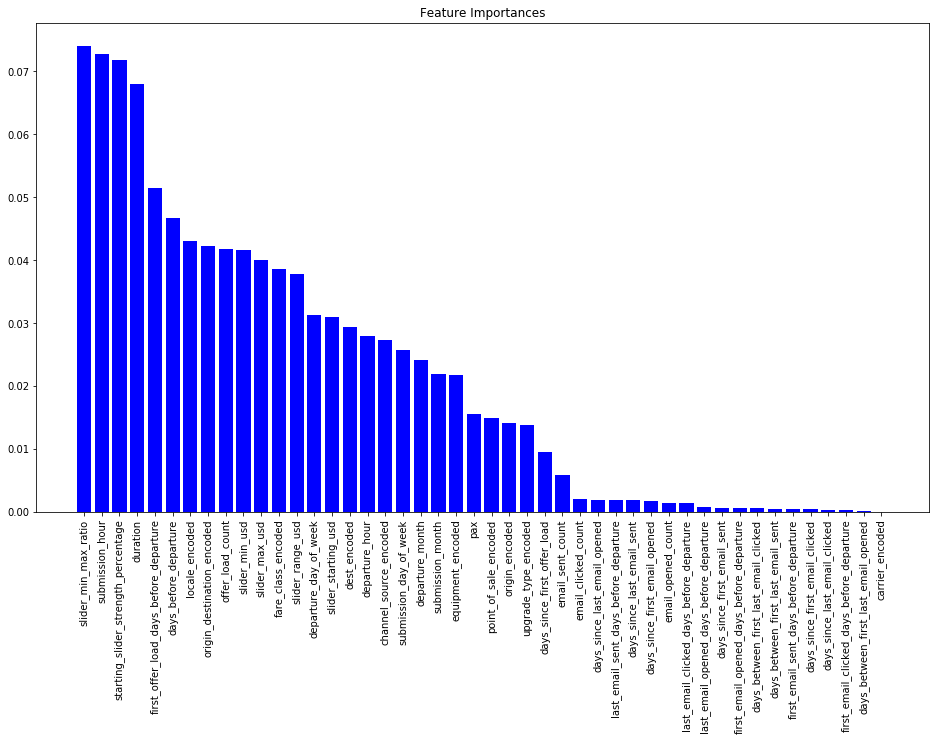

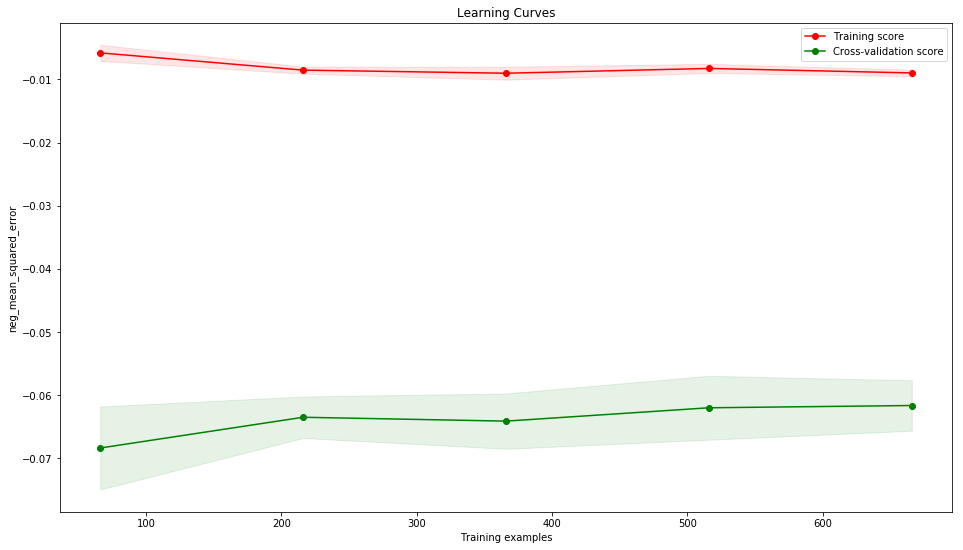

In [51]:
# run with a smaller subset to sanity check + the learning curves
train_and_evaluate(df,plot_learning_curves=True,limit=1000)

training on 7000 rows...
training is done!
testing on 3000 rows...
Lower is better
mean_squared_error 0.061009095801623406
mean_absolute_error 0.183712003123804
median_absolute_error 0.14665906362105316
Higher is better
explained_variance_score 0.06351477700215569
r2_score 0.060481694070260605


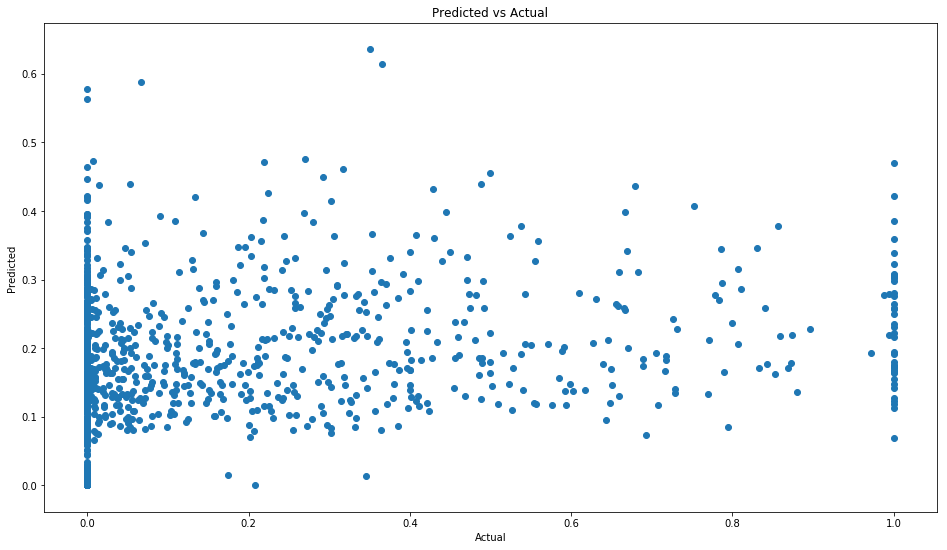

In [52]:
# run with a lot of data
train_and_evaluate(df,plot_learning_curves=False,limit=10000, plot_sample_predicted_vs_actual=True)

In [ ]:
# run with all of data
train_and_evaluate(df,plot_learning_curves=False, plot_sample_predicted_vs_actual=True)

training on 75884 rows...


training on 87590 rows...
training is done!
testing on 20817 rows...
Lower is better
mean_squared_error 0.056328260292886415
mean_absolute_error 0.1857973229518586
median_absolute_error 0.16381208605437989
Higher is better
explained_variance_score 0.06997524334068128
r2_score 0.011769121254616821


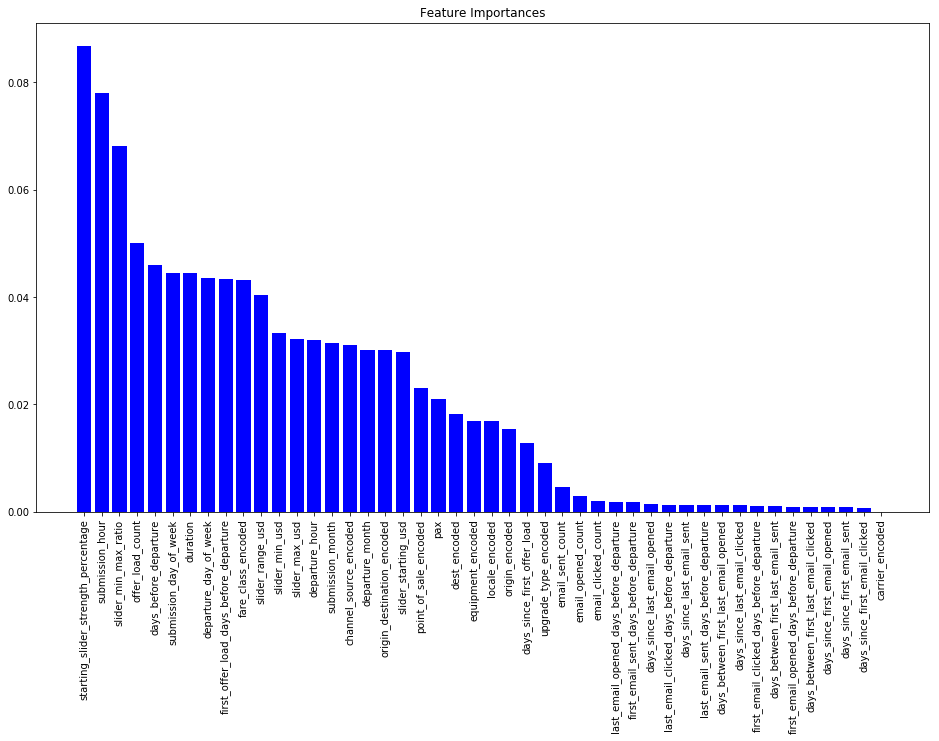

In [50]:
# run with a lot of data split on time (year 2019 vs 2020)
train_and_evaluate(df,plot_learning_curves=False,plot_sample_predicted_vs_actual=True, split_on_time=True)